In [1]:
    #Basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv
import random
    #Imputing missing values
from sklearn.impute import SimpleImputer 
    #Changing names
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    #Splitting database
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
    #Changing scales
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
    #Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
    #Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    #Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, recall_score
#import scikitplot as skplt
import shap
import scipy.stats as stats

# 1 Load Split Data

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [3]:
y_train = y_train.squeeze().values  # This converts the DataFrame to a numpy array
y_test = y_test.squeeze().values  # This converts the DataFrame to a numpy array

# some models in scikit-learn expect the target variable y to be a one-dimensional array, but you might be passing a two-dimensional array (or column-vector) instead. You can use the ravel() function to convert y_train and y_test into one-dimensional arrays.

In [4]:
X_train.shape, X_test.shape

((2003, 9), (501, 9))

In [5]:
X_train.head()

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,PAXMINSB,PAXMINLPA,PAXMINMPA,PAXMINVPA,PAXMINVVPA
0,76988.0,1.0,67.0,68.3,55.180460,271.081575,226.268674,20.398862,0.425658
1,82083.0,2.0,57.0,67.4,54.249962,349.396124,403.947424,111.523810,11.183867
2,75435.0,2.0,63.0,60.3,75.901543,298.740069,458.557302,63.265076,2.150472
3,76741.0,2.0,68.0,70.1,84.972456,257.353975,277.324868,45.859348,2.212542
4,78834.0,2.0,56.0,57.1,48.954254,330.458856,458.479079,84.496932,5.680614


Drop SEQN column

In [6]:
X_train = X_train.drop(['SEQN'], axis=1)
X_test = X_test.drop(['SEQN'], axis=1)

In [7]:
X_train.columns

Index(['RIAGENDR', 'RIDAGEYR', 'BMXWT', 'PAXMINSB', 'PAXMINLPA', 'PAXMINMPA',
       'PAXMINVPA', 'PAXMINVVPA'],
      dtype='object')

# 2 Scale Normalization

In [8]:
# Instantiate an object of that class
scaler = StandardScaler() #MinMaxScaler() #RobustScaler() #MaxAbsScaler()

# Fit the transformer to the data (learning)
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assign
X_train = X_train_scaled
X_test = X_test_scaled

# 3 Models + Hyperparameter Optimization

### Decision tree

In [9]:
estimator = DecisionTreeClassifier()

# Define the hyperparameter grid
parameters={'max_depth': [4,6,8,10,12],
           'criterion': ['gini','entropy'],
           'splitter': ['best','random'],
           'min_weight_fraction_leaf': [0.0,0.1,0.2,0.3],
           'min_impurity_decrease': [0.0,0.05,0.1,0.2]}

# Create the GridSearchCV object
model_dt = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     verbose=1,
                     n_jobs=-1,
                     refit=True,
                     scoring='roc_auc')# Use threshold independent metrics! Recall is not a good a choice-->use ROC AUC instead (because dataset is balanced) or precision-recall curve AUC

# Fit the model
model_dt.fit(X_train, y_train)

# Get the model parameters
print("Best parameters found: ")
print(model_dt.best_estimator_)
print(model_dt.best_params_)
print(f"Best roc_auc: %.1f%%"% (model_dt.best_score_*100.0))

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
Best parameters found: 
DecisionTreeClassifier(criterion='entropy', max_depth=4)
{'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Best roc_auc: 74.8%


### SVC

In [10]:
# Define the SVC estimator
estimator = SVC(probability=True) #When you set probability=True for the SVC (Support Vector Machine Classifier) in scikit-learn, it enables the classifier to provide probability estimates for predictions. By default, SVMs do not directly provide probability estimates.

# Define the hyperparameter distribution
param_dist = {
    'C': stats.uniform(0.1, 10),  # Continuous uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(stats.uniform(0.1, 1).rvs(1)),  # Adding some random gamma values
    'shrinking': [True, False],
    'degree': stats.randint(2, 5),  # Degree for 'poly' kernel. Integers between 2 and 5.
    'coef0': stats.uniform(0, 4),  # Uniform distribution between 0 and 4
}

# Create the RandomizedSearchCV object - MUY LENTO!!
model_svc = RandomizedSearchCV(estimator=estimator,
                           param_distributions=param_dist,
                           n_iter=20,  # Number of parameter settings that are sampled. Increase if needed.
                           cv=KFold(n_splits=5, shuffle=True, random_state=42),  # Reducing to 5-fold CV for speed
                           verbose=1,
                           scoring='roc_auc',
                           n_jobs=-1,
                           random_state=42,
                           refit=True)

# Fit the model
model_svc.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters found: ")
print(model_svc.best_estimator_)
print(model_svc.best_params_)
print(f"Best roc_auc: %.1f%%"% (model_svc.best_score_*100.0))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: 
SVC(C=1.9182496720710063, coef0=0.7336180394137353, gamma='auto',
    kernel='linear', probability=True, shrinking=False)
{'C': 1.9182496720710063, 'coef0': 0.7336180394137353, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'shrinking': False}
Best roc_auc: 76.6%


### Random Forest Classifier

In [11]:
# Define the RandomForestClassifier estimator
estimator = RandomForestClassifier()

# Define the hyperparameter grid
parameters = {
    'n_estimators': [5, 10, 20],  # Number of trees in the forest
    'max_depth': [None, 3, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Create the GridSearchCV object
model_rf = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     verbose=1,
                     scoring='roc_auc',
                     n_jobs=-1,  # Use all available cores
                     refit=True)  # Refit the model with the best parameters found

# Fit the model
model_rf.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters found: ")
print(model_rf.best_estimator_)
print(model_rf.best_params_)
print(f"Best roc_auc: %.1f%%"% (model_rf.best_score_*100.0))

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best parameters found: 
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=20)
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}
Best roc_auc: 76.7%


### Logistic Regression

In [12]:
estimator = LogisticRegression()

# Define the hyperparameter grid
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'l1_ratio': np.linspace(0, 1, 5)  # If using elasticnet
}

# Create the GridSearchCV object
model_lr = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     verbose=0,
                     scoring='roc_auc', #changing the scoring strategy
                     n_jobs=-1,
                     refit=True)

# Fit the model
model_lr.fit(X_train, y_train)

# Get the model parameters
print("Best parameters found: ")
print(model_lr.best_estimator_)
print(model_lr.best_params_)
print(f"Best roc_auc: %.1f%%"% (model_lr.best_score_*100.0))

Best parameters found: 
LogisticRegression(C=0.1, l1_ratio=0.0, solver='liblinear')
{'C': 0.1, 'l1_ratio': 0.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best roc_auc: 77.3%



3600 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Horacio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Horacio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Horacio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _chec

### Naïve Bayes

In [13]:
# Define the estimator
estimator = GaussianNB()

# Define the hyperparameter grid
parameters = {
    'var_smoothing': np.logspace(0,-9, num=100)  # Using a log scale for var_smoothing for a wider search range
}

# Create the GridSearchCV object
model_nb = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10), #YOU DON'T NEED SO MANY. IF N_SPLITS IS HIGH, THEN THE MODEL WILL HAVE LITTLE DATA TO TRAIN. TRY LESS, AROUND 3-5
                     verbose=1,
                     scoring='roc_auc',
                     n_jobs=-1,
                     refit=True) 

# Fit the model
model_nb.fit(X_train, y_train) #I DON'T NEED TO FIT AGAIN IF REFIT = TRUE

# Get the model parameters
print("Best parameters found: ")
print(model_nb.best_estimator_)
print(model_nb.best_params_)
print(f"Best roc_auc: %.1f%%"% (model_nb.best_score_*100.0))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found: 
GaussianNB(var_smoothing=1.0)
{'var_smoothing': 1.0}
Best roc_auc: 75.2%


# 4 Testing performance

Some functions to report performance of the models

In [14]:
def metrics_score(actual, predicted):
    report = classification_report(actual, predicted, output_dict=True)
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Normal', 'Osteo'], yticklabels=['Normal', 'Osteo'], cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return report

In [15]:
def evaluate_overfitting(train_report: dict, test_report: dict, threshold=0.2) -> str:
    """
    Evaluate if a model is overfitting based on the performance metrics of the training and test sets.

    Parameters:
    - train_report (dict): Classification report for the training set.
    - test_report (dict): Classification report for the test set.
    - threshold (float): The acceptable difference in performance between the training and test sets.

    Returns:
    - str: A statement indicating if the model is likely overfitting.
    """
    
    # Extract weighted average f1-scores for training and test sets
    train_f1 = train_report['weighted avg']['f1-score']
    test_f1 = test_report['weighted avg']['f1-score']
    
    # Check if the difference in f1-scores exceeds the threshold
    if train_f1 - test_f1 > threshold:
        return "The model is likely overfitting."
    else:
        return "The model doesn't seem to be overfitting."

Training and evaluating the models (using the parameters found in the hyperparameter optimization step)

---------DecisionTreeClassifier---------

Recall: 50.8%
Cross-Validation Recall: 47.2% (7.0%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81      1225
         1.0       0.75      0.50      0.60       778

    accuracy                           0.74      2003
   macro avg       0.74      0.70      0.70      2003
weighted avg       0.74      0.74      0.73      2003



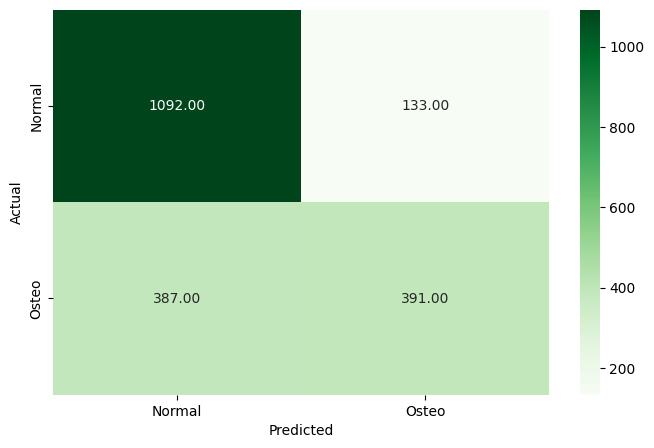

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81       306
         1.0       0.75      0.51      0.61       195

    accuracy                           0.74       501
   macro avg       0.74      0.70      0.71       501
weighted avg       0.74      0.74      0.73       501



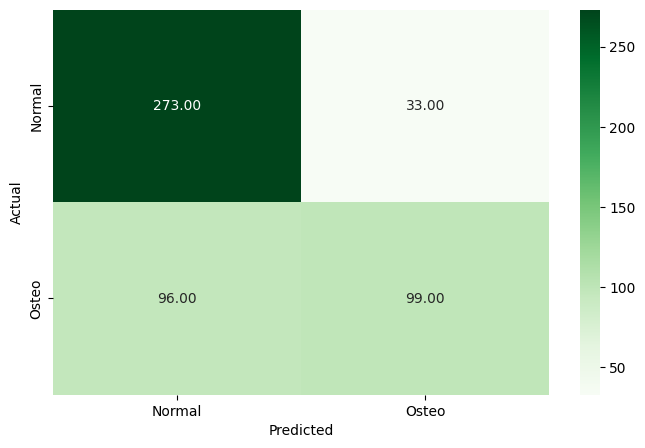

The model doesn't seem to be overfitting.

------------------SVC-------------------

Recall: 54.4%
Cross-Validation Recall: 55.9% (4.9%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79      1225
         1.0       0.68      0.57      0.62       778

    accuracy                           0.73      2003
   macro avg       0.71      0.70      0.70      2003
weighted avg       0.72      0.73      0.72      2003



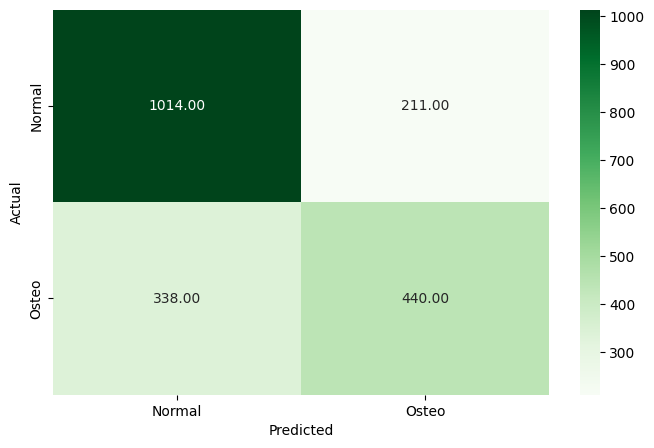

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       306
         1.0       0.65      0.54      0.59       195

    accuracy                           0.71       501
   macro avg       0.69      0.68      0.68       501
weighted avg       0.70      0.71      0.70       501



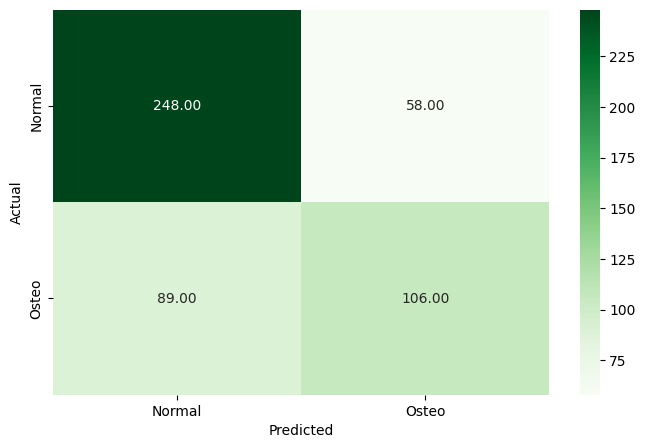

The model doesn't seem to be overfitting.

---------RandomForestClassifier---------

Recall: 51.8%
Cross-Validation Recall: 48.9% (5.6%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      1225
         1.0       0.76      0.55      0.64       778

    accuracy                           0.76      2003
   macro avg       0.76      0.72      0.73      2003
weighted avg       0.76      0.76      0.75      2003



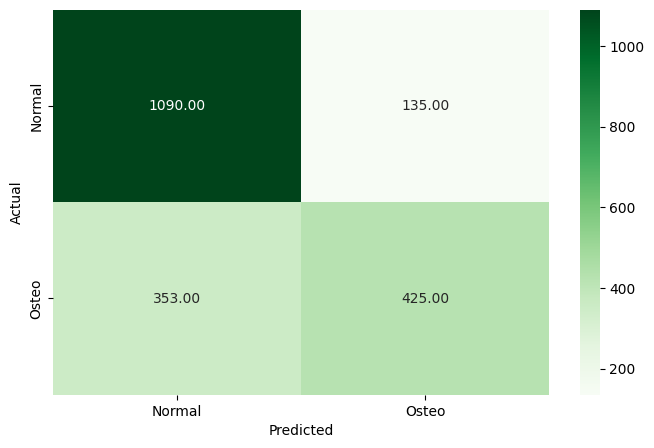

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81       306
         1.0       0.75      0.52      0.61       195

    accuracy                           0.74       501
   macro avg       0.75      0.70      0.71       501
weighted avg       0.75      0.74      0.73       501



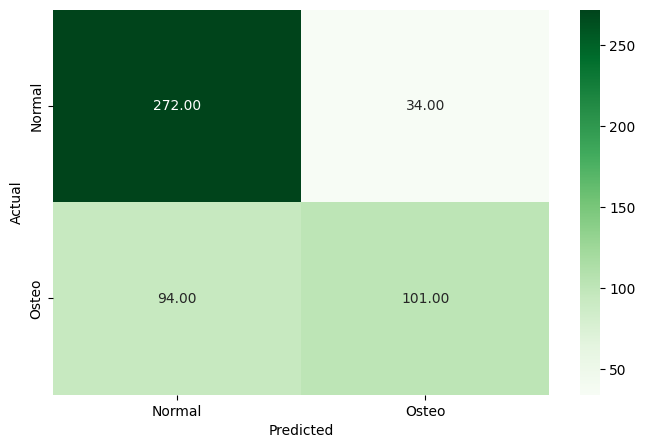

The model doesn't seem to be overfitting.

-----------LogisticRegression-----------

Recall: 56.4%
Cross-Validation Recall: 56.0% (5.2%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.79      1225
         1.0       0.67      0.57      0.61       778

    accuracy                           0.72      2003
   macro avg       0.71      0.70      0.70      2003
weighted avg       0.72      0.72      0.72      2003



l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


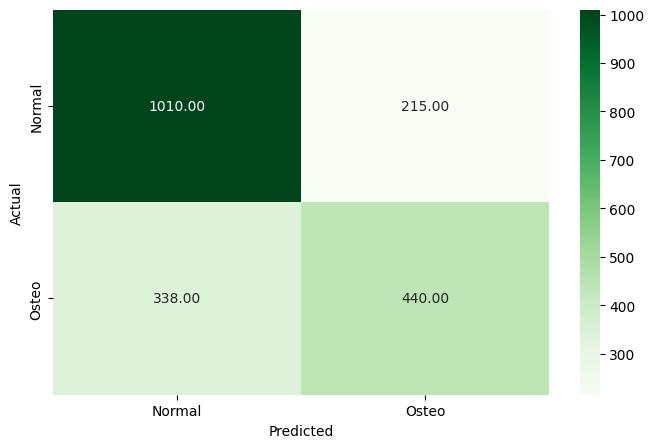

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       306
         1.0       0.66      0.56      0.61       195

    accuracy                           0.72       501
   macro avg       0.70      0.69      0.69       501
weighted avg       0.71      0.72      0.71       501



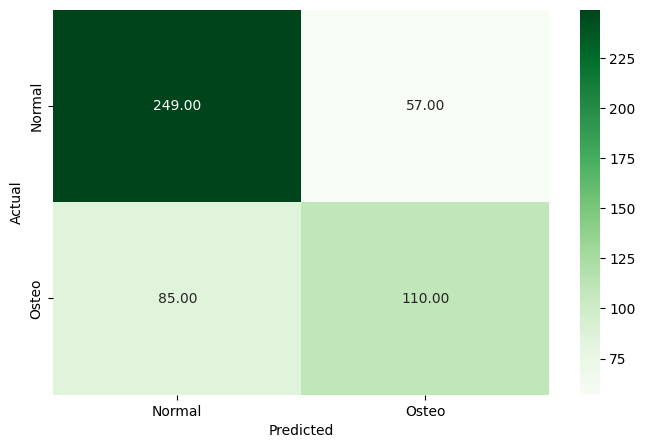

The model doesn't seem to be overfitting.

---------------GaussianNB---------------

Recall: 38.5%
Cross-Validation Recall: 38.4% (4.6%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80      1225
         1.0       0.75      0.41      0.53       778

    accuracy                           0.72      2003
   macro avg       0.73      0.66      0.66      2003
weighted avg       0.72      0.72      0.69      2003



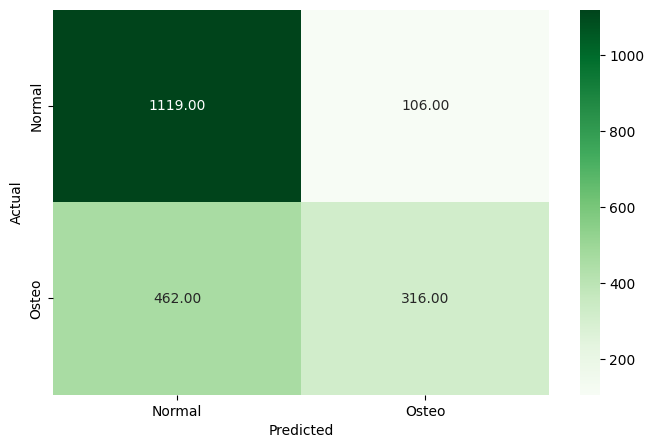

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79       306
         1.0       0.72      0.38      0.50       195

    accuracy                           0.70       501
   macro avg       0.71      0.64      0.64       501
weighted avg       0.71      0.70      0.68       501



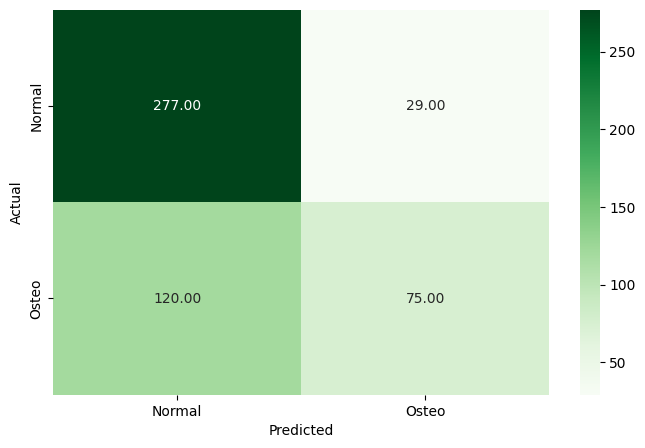

The model doesn't seem to be overfitting.



In [16]:
models = [
    DecisionTreeClassifier(**model_dt.best_params_), 
    SVC(**model_svc.best_params_), 
    RandomForestClassifier(**model_rf.best_params_), 
    LogisticRegression(**model_lr.best_params_),
    GaussianNB(**model_nb.best_params_)
]

#models = [
#    DecisionTreeClassifier(), 
#    RandomForestClassifier(), 
#    SVC(), 
#    LogisticRegression()
#]

for model in models:
    print(f'{model.__class__.__name__}'.center(40, '-') + '\n')

    # 1. TRAIN THE MODEL
    model.fit(X_train, y_train) #THIS WAS NOT NECESSARY. WE DON'T NEED TO FIT AGAIN IF REFIT = TRUE, NOR DO CROSS-VALIDATION

    # 2. EVALUATE THE MODEL

    #IMPORTANT!! WE ARE USING THE TEST SET TO COMPARE THE MODELS. THIS IS AN ERROR, TESTS SET PERFORMANCE SHOULDN'T BE USED TO DECIDE BETWEEN MODELS. THE TEST SET IS JUST TO COMMUNICATE THE ERROR IN UNSEEN DATA. WE NEED TO CHOOSE THE BEST MODEL FROM THE TRAIN SET. VALIDATION SET FOR THE THRESHOLDS
    # 
    # a) Recall
    y_pred = model.predict(X_test)
    print(f'Recall: {(recall_score(y_test, y_pred)*100).round(1)}%')

    # b) Cross-validation: Use StratifiedKFold for cross-validation for each model
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')  # Using 'recall' for binary classification
    print(f"Cross-Validation Recall: %.1f%% (%.1f%%)" % (results.mean()*100.0, results.std()*100.0) + '\n')
    
    # c) Evaluate the model: Print classification report and confusion matrix for train and test
    print("TRAIN".center(50))
    train_classification_report = metrics_score(y_train, model.predict(X_train))
    print("TEST".center(50))
    test_classification_report = metrics_score(y_test, model.predict(X_test))

    # 3. OVERFITTING EVALUATION
    print(evaluate_overfitting(train_classification_report, test_classification_report)+ '\n')